# Project Objective

The primary objective of this analysis is to perform unsupervised clustering on the banana quality dataset. The goal is to identify natural groupings or segments within the data based on the bananas' physical and chemical attributes, without using any pre-existing labels.

The model's focus is squarely on clustering, utilizing three distinct techniques (K-Means, Agglomerative, and DBSCAN) to partition the data. This analysis does not involve dimensionality reduction.

The benefits of this analysis to stakeholders are manifold:

  - Market Segmentation: By identifying distinct clusters (e.g., 4 optimal clusters were found), a business can create different grades of bananas (premium, standard, processing-grade) for targeted pricing and marketing strategies, potentially maximizing revenue.

  - Quality Control Insight: The analysis provides a more nuanced understanding of quality beyond a simple "Good" or "Bad" label. Investigating the characteristics of each cluster can help pinpoint specific attributes that lead to different quality levels, improving harvesting and supply chain processes.

  - Discovery of Hidden Patterns: The analysis suggests that the data naturally groups into four clusters, which is more detailed than the original binary classification. This uncovers hidden structures in the data,

# Importing Necessary library

In [ ]:
!pip install kneed

In [184]:
# Importing the warnings library to control warning messages
import warnings

# Ignoring all warnings to prevent them from showing up in the output
warnings.filterwarnings('ignore')

In [185]:
# --- Core Libraries ---
import pandas as pd  # For data manipulation (DataFrames)
import numpy as np  # For numerical operations (arrays)
import math  # For basic mathematical functions
import itertools  # For creating efficient iterators

# --- Visualization ---
import seaborn as sns  # For statistical plotting
import matplotlib.pyplot as plt  # For general-purpose plotting
%matplotlib inline


# --- Preprocessing & Splitting ---
from sklearn.preprocessing import StandardScaler  # For feature scaling
from sklearn.model_selection import StratifiedShuffleSplit  # For stratified train-test splitting

# --- Machine Learning Models ---
from sklearn.linear_model import LogisticRegression  # Classification model
from sklearn.cluster import KMeans  # K-Means clustering algorithm
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN # DBSCAN algorithm
from sklearn.neighbors import NearestNeighbors  # For finding nearest data points

# --- Evaluation & Utilities ---
from kneed import KneeLocator  # To find the optimal 'k' for clustering (elbow method)
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score  # For evaluating clustering performance
from sklearn.metrics import silhouette_score
from scipy.cluster import hierarchy

# Understanding Data

The analysis uses the banana_quality.csv dataset. It contains measurements of various attributes for a sample of bananas to determine their quality.

Dataset Attributes: The dataset consists of 8 columns:

  - 7 Numerical Features: Size, Weight, Sweetness, Softness, HarvestTime, Ripeness, Acidity.

  - 1 Categorical Target Feature: Quality (with "Good" and "Bad" labels).

Analysis Goal: The primary goal is to apply unsupervised learning algorithms to group the bananas based on the seven numerical features. The Quality column is intentionally set aside during the training phase and is used only as a "ground truth" benchmark during the evaluation phase to assess how well the discovered clusters align with a known, human-defined classification.

In [186]:
# Load the dataset from a CSV file named 'banana_quality.csv' into a pandas DataFrame.
df = pd.read_csv('banana_quality.csv')

# Display the first 10 rows of the DataFrame to get a quick overview of the data.
df.head(10)

,Size,Weight,Sweetness,Softness,HarvestTime,Ripeness,Acidity,Quality
0,-1.924968,0.468078,3.077832,-1.472177,0.294799,2.435570,0.271290,Good
1,-2.409751,0.486870,0.346921,-2.495099,-0.892213,2.067549,0.307325,Good
2,-0.357607,1.483176,1.568452,-2.645145,-0.647267,3.090643,1.427322,Good
3,-0.868524,1.566201,1.889605,-1.273761,-1.006278,1.873001,0.477862,Good
4,0.651825,1.319199,-0.022459,-1.209709,-1.430692,1.078345,2.812442,Good
5,-2.807722,1.138136,3.447627,-1.713302,-2.220912,2.079410,2.281203,Good
6,-0.230208,2.783471,1.681184,-0.529779,-1.958468,1.348143,2.181766,Good
7,-1.348515,3.232281,4.011817,-0.890606,-0.031994,2.395917,1.042878,Good
8,-2.012226,1.928034,0.698746,-0.959772,-1.349721,1.311802,1.048762,Good
9,0.053035,1.309993,-0.264139,-2.969297,0.303983,3.889359,1.931332,Good


In [187]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Size         8000 non-null   float64
 1   Weight       8000 non-null   float64
 2   Sweetness    8000 non-null   float64
 3   Softness     8000 non-null   float64
 4   HarvestTime  8000 non-null   float64
 5   Ripeness     8000 non-null   float64
 6   Acidity      8000 non-null   float64
 7   Quality      8000 non-null   object 
dtypes: float64(7), object(1)
memory usage: 500.1+ KB


In [188]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Size,8000.0,-0.747802,2.136023,-7.998074,-2.277651,-0.897514,0.654216,7.970800
Weight,8000.0,-0.761019,2.015934,-8.283002,-2.223574,-0.868659,0.775491,5.679692
Sweetness,8000.0,-0.770224,1.948455,-6.434022,-2.107329,-1.020673,0.311048,7.539374
Softness,8000.0,-0.014441,2.065216,-6.959320,-1.590458,0.202644,1.547120,8.241555
HarvestTime,8000.0,-0.751288,1.996661,-7.570008,-2.120659,-0.934192,0.507326,6.293280
Ripeness,8000.0,0.781098,2.114289,-7.423155,-0.574226,0.964952,2.261650,7.249034
Acidity,8000.0,0.008725,2.293467,-8.226977,-1.629450,0.098735,1.682063,7.411633


In [189]:
# Select all columns with numerical data types and store their names in a list.
numerical_feature = df.select_dtypes(include=np.number).columns

# Select all columns with non-numerical data types and store their names in a list.
categorical_feature = df.select_dtypes(exclude=np.number).columns

In [190]:
numerical_feature = list(numerical_feature)
numerical_feature

['Size',
 'Weight',
 'Sweetness',
 'Softness',
 'HarvestTime',
 'Ripeness',
 'Acidity']

In [191]:
categorical_feature

Index(['Quality'], dtype='object')

In [192]:
# Loop through the list of categorical column names.
for i in categorical_feature:
    # For each column, count the unique values and their frequencies, then print the result.
    print(df[i].value_counts(), "\n")

Quality
Good    4006
Bad     3994
Name: count, dtype: int64 



# Cleaning and Feature Engineering

Data Exploration: The initial exploration phase revealed that the dataset was of high quality. An analysis using .info() and .isnull().sum() confirmed there were no missing values, and a check using .duplicated() showed there were no duplicate rows.

Data Cleaning & Engineering: The following key actions were taken:

  - Label Encoding: The categorical Quality feature was converted into a numerical format (Good: 1, Bad: 0). This was done specifically for the evaluation stage, not for training the clustering models.

  - Feature Scaling: All numerical features were standardized using StandardScaler. This is a critical step that ensures each feature contributes equally to the clustering process. Since clustering algorithms like K-Means are distance-based, this prevents features with naturally larger scales (like Weight) from disproportionately influencing the results over features with smaller scales (like Acidity).

In [193]:
# Create a copy of the original dataframe to preserve the original data
df_cleaned = df.copy()


In [194]:
# Check for missing values in each column of the dataframe and display the total count per column
df_cleaned.isnull().sum()


,0
Size,0
Weight,0
Sweetness,0
Softness,0
HarvestTime,0
Ripeness,0
Acidity,0
Quality,0


In [195]:
# Find all duplicate rows in the dataframe
duplicate_rows = df_cleaned[df_cleaned.duplicated()]

# Display the duplicate rows
duplicate_rows

,Size,Weight,Sweetness,Softness,HarvestTime,Ripeness,Acidity,Quality


In [196]:
# Create a dictionary to define the mapping from string labels to numbers.
mapping = {'Good': 1, 'Bad': 0}

# Apply the mapping to the 'Quality' column to replace strings with numbers,
# then ensure the column's data type is integer.
df_cleaned['Quality'] = df_cleaned['Quality'].map(mapping).astype(int)

In [197]:
df_cleaned['Quality']

,Quality
0,1
1,1
2,1
3,1
4,1
...,...
7995,0
7996,0
7997,0
7998,0


In [198]:
# Create an instance of the StandardScaler object.
scaler = StandardScaler()

# Standardize the numerical features.
# This calculates the mean and standard deviation for each numerical column and then scales the data.
df_cleaned[numerical_feature] = scaler.fit_transform(df_cleaned[numerical_feature])


In [199]:
df_cleaned

,Size,Weight,Sweetness,Softness,HarvestTime,Ripeness,Acidity,Quality
0,-0.551136,0.609729,1.975051,-0.705896,0.523951,0.782568,0.114491,1
1,-0.778107,0.619052,0.573385,-1.201237,-0.070585,0.608493,0.130204,1
2,0.182685,1.113298,1.200347,-1.273895,0.052101,1.092419,0.618577,1
3,-0.056521,1.154485,1.365182,-0.609815,-0.127716,0.516472,0.204566,1
4,0.655290,1.031953,0.383797,-0.578798,-0.340291,0.140598,1.222556,1
...,...,...,...,...,...,...,...,...
7995,-2.653041,0.736471,0.977850,1.436842,0.525518,-0.443697,1.041879,0
7996,0.748609,-0.722715,-1.048050,0.243907,-0.286557,-1.465351,0.917625,0
7997,1.016216,-0.568827,-0.904435,0.474274,0.094620,-1.237308,0.300279,0
7998,-0.648022,-0.983020,-0.122055,1.036948,-0.025716,-2.062933,0.180892,0


In [200]:
df_cleaned.describe().T

,count,mean,std,min,25%,50%,75%,max
Size,8000.0,0.000000e+00,1.000063,-3.394498,-0.716259,-0.070094,0.656409,4.081954
Weight,8000.0,2.842171e-17,1.000063,-3.731497,-0.725543,-0.053398,0.762231,3.195101
Sweetness,8000.0,-1.136868e-16,1.000063,-2.906996,-0.686282,-0.128545,0.554973,4.264978
Softness,8000.0,0.000000e+00,1.000063,-3.362996,-0.763172,0.105121,0.756172,3.997893
HarvestTime,8000.0,5.684342e-17,1.000063,-3.415275,-0.685873,-0.091611,0.630399,3.528395
Ripeness,8000.0,0.000000e+00,1.000063,-3.880626,-0.641071,0.086963,0.700304,3.059344
Acidity,8000.0,5.684342e-17,1.000063,-3.591165,-0.714324,0.039249,0.729656,3.228027
Quality,8000.0,5.007500e-01,0.500031,0.000000,0.000000,1.000000,1.000000,1.000000


In [201]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Size         8000 non-null   float64
 1   Weight       8000 non-null   float64
 2   Sweetness    8000 non-null   float64
 3   Softness     8000 non-null   float64
 4   HarvestTime  8000 non-null   float64
 5   Ripeness     8000 non-null   float64
 6   Acidity      8000 non-null   float64
 7   Quality      8000 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 500.1 KB


# Training Data

The analysis explored three different unsupervised clustering models to understand the data's structure from multiple perspectives.

  - K-Means Clustering: This model was trained to partition the data into a pre-defined number of clusters. The optimal number of clusters (k) was determined to be 4 by using the Silhouette Score as an evaluation metric, which measures how well-separated the clusters are.

  - Agglomerative Hierarchical Clustering: This technique builds a hierarchy of clusters. Similar to K-Means, the optimal number of clusters was identified as 4 using the Silhouette Score. A dendrogram was also plotted to visualize the hierarchical relationships between the data points.

  - DBSCAN (Density-Based Clustering): This model groups together points that are closely packed, marking as outliers points that lie alone in low-density regions. The optimal eps parameter was systematically found using a K-distance plot. The model concluded that there was only 1 large cluster and 13 noise points, indicating that the data is not structured in a way that is suitable for density-based clustering.

# K-Mean Clustering

For k=2, the silhouette score is 0.2216
For k=3, the silhouette score is 0.2262
For k=4, the silhouette score is 0.2350
For k=5, the silhouette score is 0.2224
For k=6, the silhouette score is 0.2136
For k=7, the silhouette score is 0.1942
For k=8, the silhouette score is 0.1801
For k=9, the silhouette score is 0.1865
For k=10, the silhouette score is 0.1885

Optimal k based on highest Silhouette Score: 4


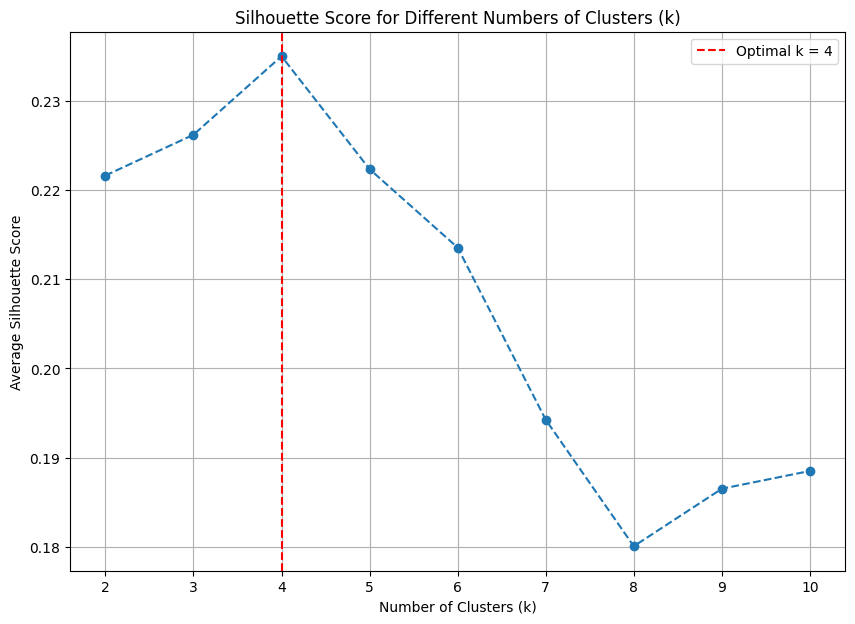

In [202]:
# A list to store silhouette scores for each k
silhouette_scores = []
# The range of k we want to test
# Note: Silhouette score is only defined for n_clusters >= 2
list_num_clusters = list(range(2, 11))

for num_clusters in list_num_clusters:
    # Initialize and fit KMeans
    km = KMeans(n_clusters=num_clusters, init='k-means++', n_init='auto', random_state=42)
    km.fit(df_cleaned[numerical_feature])

    # Get the cluster labels for each point
    labels = km.labels_

    # Calculate the average silhouette score
    score = silhouette_score(df_cleaned[numerical_feature], labels)
    silhouette_scores.append(score)
    print(f"For k={num_clusters}, the silhouette score is {score:.4f}")

# Find the optimal k which has the highest score
optimal_k_silhouette = list_num_clusters[np.argmax(silhouette_scores)]
print(f"\nOptimal k based on highest Silhouette Score: {optimal_k_silhouette}")

# Plot the silhouette scores
plt.figure(figsize=(10, 7))
plt.plot(list_num_clusters, silhouette_scores, marker='o', linestyle='--')
# Highlight the optimal k
plt.axvline(x=optimal_k_silhouette, color='red', linestyle='--', label=f'Optimal k = {optimal_k_silhouette}')
plt.title('Silhouette Score for Different Numbers of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.xticks(list_num_clusters)
plt.legend()
plt.grid(True)
plt.show()

In [181]:
# Define a function to visualize 2D data clusters.
# X: The data (e.g., a NumPy array with at least 2 columns).
# km: A trained clustering model object (like KMeans) which has .labels_ and .cluster_centers_ attributes.
# num_clusters: The number of clusters found by the model.
def display_cluster(X, km=[], num_clusters=0):
    # Define a set of colors for the clusters.
    color = 'brgcmyk'
    # Set the transparency for the data points.
    alpha = 0.5
    # Set the size for the data points.
    s = 20

    # If no clusters are specified, plot all data in a single color.
    if num_clusters == 0:
        plt.scatter(X[:,0], X[:,1], c=color[0], alpha=alpha, s=s)
    # Otherwise, plot each cluster in a different color.
    else:
        # Loop through each cluster.
        for i in range(num_clusters):
            # Plot the data points belonging to the current cluster.
            # It selects data points where the label matches the current cluster index 'i'.
            plt.scatter(X[km.labels_==i, 0], X[km.labels_==i, 1], c=color[i], alpha=alpha, s=s)

            # Plot the center of the current cluster as a large 'x'.
            plt.scatter(km.cluster_centers_[i][0], km.cluster_centers_[i][1], c=color[i], marker='x', s=100)

In [203]:
# Set the number of clusters to the optimal value found previously (e.g., via silhouette score).
num_clusters = optimal_k_silhouette

# Initialize the KMeans model with the specified number of clusters and parameters for better performance and reproducibility.
km = KMeans(n_clusters=num_clusters, init='k-means++', n_init='auto', random_state=42)

# Train (fit) the KMeans model on the preprocessed numerical data.
# The model learns the cluster centers from the data.
km = km.fit(df_cleaned[numerical_feature])

# Use the trained model to predict the cluster for each data point (row).
# Store these cluster labels in a new column named 'kmeans' in the DataFrame.
df_cleaned['kmeans'] = km.predict(df_cleaned[numerical_feature])

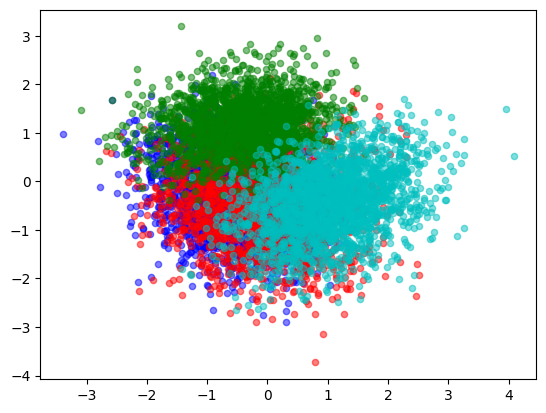

In [238]:
display_cluster(df_cleaned[numerical_feature].values,km,num_clusters)

## Agglomerative Hierarchical Clustering

In [208]:
# --- Finding Optimal K for Agglomerative Clustering using Silhouette Score ---

# Create an empty list to store the silhouette scores for each value of k.
silhouette_scores = []

# Define the range of cluster numbers (k) to test, from 2 to 10.
k_range = range(2, 11)

# Loop through each possible number of clusters.
for k in k_range:
    # Initialize the Agglomerative Clustering model for the current value of k.
    # 'linkage='ward'' is a method that minimizes the variance within each cluster.
    agglo = AgglomerativeClustering(n_clusters=k, linkage='ward')

    # Fit the model to the data and get the cluster labels for each data point.
    labels = agglo.fit_predict(df_cleaned[numerical_feature])

    # Calculate the silhouette score, which measures how well-defined the clusters are.
    score = silhouette_score(df_cleaned[numerical_feature], labels)

    # Add the calculated score to our list.
    silhouette_scores.append(score)

    # Print the score for the current k.
    print(f"For k={k}, Silhouette Score is {score:.4f}")

# Find the number of clusters (k) that resulted in the highest silhouette score.
# np.argmax() finds the index of the highest score.
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nThe amount of optimal clusters based on Silhoute Score is: {optimal_k}")

For k=2, Silhouette Score is 0.1917
For k=3, Silhouette Score is 0.2101
For k=4, Silhouette Score is 0.2124
For k=5, Silhouette Score is 0.1977
For k=6, Silhouette Score is 0.1793
For k=7, Silhouette Score is 0.1712
For k=8, Silhouette Score is 0.1487
For k=9, Silhouette Score is 0.1423
For k=10, Silhouette Score is 0.1360

The amount of optimal clusters based on Silhoute Score is: 4


In [209]:
# Set the desired number of clusters to 4.
num_clusters = 4

# Initialize the Agglomerative Clustering model with 4 clusters.
# 'linkage='ward'' minimizes variance within clusters.
# 'compute_full_tree=True' ensures the entire hierarchy is built, useful for dendrograms.
ag = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward', compute_full_tree=True)

# This line fits the model to the data but its result isn't used. It's redundant.
ag = ag.fit(df_cleaned[numerical_feature])

# This single line fits the model AGAIN and then predicts the labels.
# The labels are stored in a new DataFrame column named 'agglom'.
df_cleaned['agglom'] = ag.fit_predict(df_cleaned[numerical_feature])

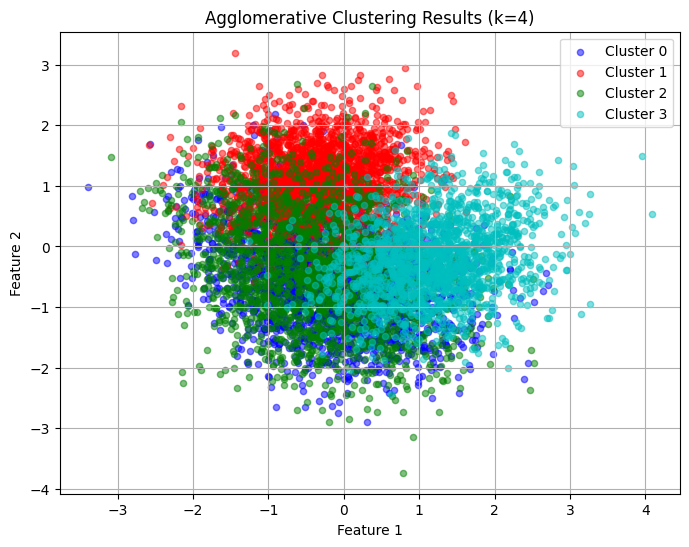

In [210]:
def display_agglomerative_cluster(X, agglo_model, num_clusters):
    """
    Visualizes the results of Agglomerative Clustering.
    """
    color = 'brgcmyk'  # Color sequence for clusters
    alpha = 0.5        # Point transparency
    s = 20             # Point size

    for i in range(num_clusters):
        # Scatter plot for data points in each cluster
        plt.scatter(X[agglo_model.labels_ == i, 0], X[agglo_model.labels_ == i, 1], c=color[i], alpha=alpha, s=s, label=f'Cluster {i}')

# 5. Call the function to display the results
plt.figure(figsize=(8, 6))
display_agglomerative_cluster(df_cleaned[numerical_feature].values, ag, num_clusters)
plt.title(f'Agglomerative Clustering Results (k={num_clusters})')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

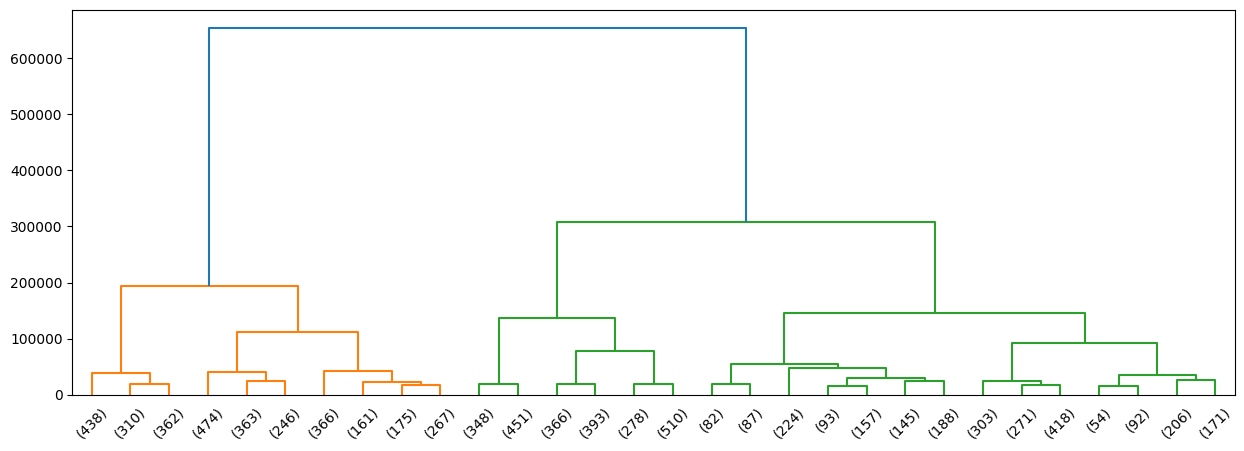

In [240]:

# Create a linkage matrix 'Z' using the 'ward' method.
# The input for the linkage is the 'children_' attribute from the previously fitted 'ag' model.
Z = hierarchy.linkage(ag.children_, method='ward')

# Set up a matplotlib figure and axes with a size of 15x5 inches for the plot.
fig, ax = plt.subplots(figsize=(15,5))

# Plot the dendrogram on the prepared axes using the linkage matrix 'Z'.
den = hierarchy.dendrogram(Z, orientation='top',
                           p=30, truncate_mode='lastp', # Truncate the plot to show only the last 30 merges.
                           show_leaf_counts=True,      # Display the number of points in each final leaf.
                           ax=ax)                     # Specify the axes to draw on.

# DBSCAN

Optimal eps value found by KneeLocator: 1.6790


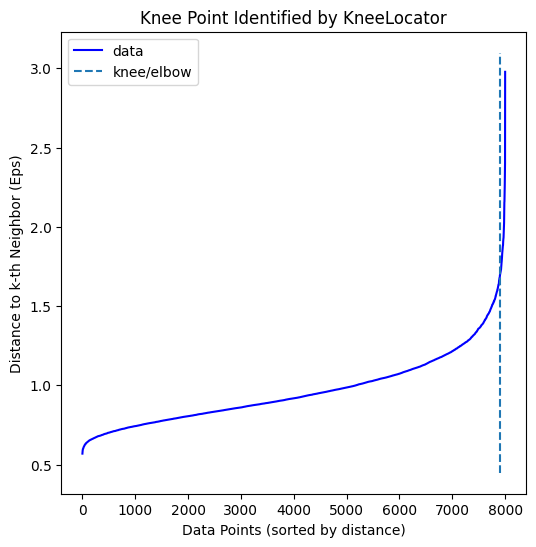

In [212]:
# A good rule of thumb is 2 * number_of_features.
min_samples_val = 14

# Set up NearestNeighbors. n_neighbors should be your chosen min_samples value.
neigh = NearestNeighbors(n_neighbors=min_samples_val)
nbrs = neigh.fit(df_cleaned[numerical_feature])
distances, indices = nbrs.kneighbors(df_cleaned[numerical_feature])

# Get the distance to the k-th nearest neighbor.
k_distances = distances[:, -1]

# Sort these distances and plot them.
k_distances_sorted = np.sort(k_distances)

# The x-axis is just the index of the points.
x_values = range(1, len(k_distances_sorted) + 1)

# Find the knee using KneeLocator
# For a k-distance plot, the curve is 'convex' and 'increasing'.
kneedle = KneeLocator(x_values, k_distances_sorted, curve='convex', direction='increasing')

# Get the optimal eps value from the knee point's y-coordinate
optimal_eps = kneedle.elbow_y

print(f"Optimal eps value found by KneeLocator: {optimal_eps:.4f}")

# visualize the result directly
kneedle.plot_knee()
plt.title("Knee Point Identified by KneeLocator")
plt.xlabel("Data Points (sorted by distance)")
plt.ylabel("Distance to k-th Neighbor (Eps)")
plt.show()


In [213]:
# Initialize the DBSCAN clustering model.
# eps: The maximum distance between two samples for one to be considered as in the neighborhood of the other.
# min_samples: The number of samples in a neighborhood for a point to be considered a core point.
dbscan_model = DBSCAN(eps=optimal_eps, min_samples=min_samples_val)

# Fit the model to the data and predict the cluster labels.
# DBSCAN groups dense points and can identify outliers as 'noise'.
cluster_labels = dbscan_model.fit_predict(df_cleaned[numerical_feature])

# Store the resulting cluster labels in a new DataFrame column named 'dbscan'.
# Noise points are given the label -1.
df_cleaned['dbscan'] = cluster_labels

In [214]:
# Calculate the number of clusters found by DBSCAN.
# It counts the unique labels and subtracts 1 if the noise label (-1) is present.
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)

# Count the total number of points that were classified as noise (labeled -1).
n_noise = list(cluster_labels).count(-1)

# Print a summary of the clustering results.
print(f'DBSCAN found {n_clusters} clusters and {n_noise} points of noise.')

DBSCAN found 1 clusters and 13 points of noise.


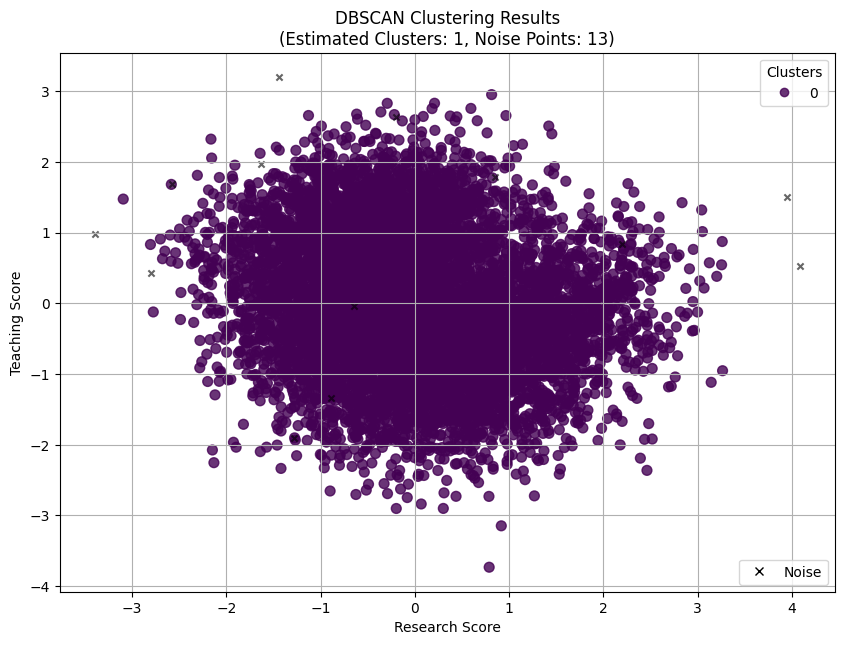

In [215]:
# Visualize the results, handling noise points separately
plt.figure(figsize=(10, 7))

# Define masks to separate core clusters from noise
# Noise mask will be for points with label -1
noise_mask = (cluster_labels == -1)
# Core mask is for all other points
core_mask = (cluster_labels != -1)

# Plot the core cluster points
# `c` parameter will color them based on their cluster label
scatter_core = plt.scatter(df_cleaned[numerical_feature].loc[core_mask, 'Size'],
                           df_cleaned[numerical_feature].loc[core_mask, 'Weight'],
                           c=df_cleaned.loc[core_mask, 'dbscan'],
                           cmap='viridis', s=50, alpha=0.8, label='Clusters')

# Plot the noise points
# Plot them in black (c='black') with a smaller size (s=20)
if np.any(noise_mask):
    plt.scatter(df_cleaned[numerical_feature].loc[noise_mask, 'Size'],
                df_cleaned[numerical_feature].loc[noise_mask, 'Weight'],
                c='black', s=20, alpha=0.6, marker='x', label='Noise')

plt.title(f'DBSCAN Clustering Results\n(Estimated Clusters: {n_clusters}, Noise Points: {n_noise})')
plt.xlabel('Research Score')
plt.ylabel('Teaching Score')

# Create a legend
# The legend for clusters is created from the scatter_core plot
try:
    legend1 = plt.legend(*scatter_core.legend_elements(), title="Clusters")
    plt.gca().add_artist(legend1)
except ValueError:
    pass # In case there are no core clusters to plot

# create a separate legend handle for the noise
if np.any(noise_mask):
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='x', color='black', label='Noise', linestyle='None')]
    plt.legend(handles=legend_elements, loc='lower right')

plt.grid(True)
plt.show()


# Evaluating

The choice of the "best" model depends on the specific business objective.

  - If the goal is to create the most mathematically distinct and compact clusters, then K-Means is the recommended model. The evaluation showed that its clusters were the most separable, with a logistic regression model being able to re-predict its cluster labels with ~99.5% accuracy.

  - However, if the goal is to find clusters that best align with the existing real-world classification of "Good" vs. "Bad" bananas, then Agglomerative Clustering is the recommended final model. It achieved a higher Adjusted Rand Index (0.37) and Adjusted Mutual Information score (0.46) when compared against the original Quality labels, indicating its structure is more meaningful in a practical, business context.

DBSCAN is not recommended as it was unable to find any meaningful cluster structure in the data. Given that aligning with business-relevant labels is often more valuable than pure mathematical separation, the Agglomerative Clustering model is the most suitable final recommendation.

In [217]:
# Create a new DataFrame 'X' that contains only the numerical feature columns from the cleaned data.
# This is standard practice for preparing data for a machine learning model.
X = df_cleaned[numerical_feature]

In [234]:
# Extract the cluster labels generated by the KMeans algorithm.
y_kmeans = df_cleaned['kmeans']

# Extract the cluster labels generated by the Agglomerative Clustering algorithm.
y_agglo = df_cleaned['agglom']

# Extract the cluster labels generated by the DBSCAN algorithm.
y_dbscan = df_cleaned['dbscan']

# Extract the original, ground truth labels from the 'Quality' column for comparison.
y_original = df_cleaned['Quality']

In [235]:
# Create a boolean mask to identify points that are NOT noise in the DBSCAN results.
# The mask will be 'True' for clustered points and 'False' for noise points (label -1).
dbscan_mask = y_dbscan != -1

# Organize all label sets into a dictionary for easy access during evaluation.
y_dict = {
    'kmeans': y_kmeans,
    'agglom': y_agglo,
    # For DBSCAN, store only the labels of the non-noise points by applying the mask.
    'dbscan': y_dbscan[dbscan_mask],
    'original': y_original
}

In [242]:
# A dictionary to store the final average scores
results = {}

print("--- Evaluating Cluster Separability using Logistic Regression ---")

# --- 4. Loop through each clustering result ---
for algorithm_name, labels in y_dict.items():

    print(f"\nEvaluating: {algorithm_name}...")

    # Adjust feature set if we filtered DBSCAN labels
    if algorithm_name == 'dbscan':
        X_eval = X[dbscan_mask]
    else:
        X_eval = X

    # Setup cross-validation and a list for scores for this algorithm
    sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
    accuracy_scores = []

    # Inner loop for cross-validation
    for train_index, test_index in sss.split(X_eval, labels):
        X_train, X_test = X_eval.iloc[train_index], X_eval.iloc[test_index]
        y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]

        if len(np.unique(y_train)) < 2:
            print("--> Skipping fold: training data only contains one class.")
            continue # Skip to the next fold
        # Train Logistic Regression to predict the cluster labels
        model = LogisticRegression(max_iter=1000) # Increased max_iter for convergence
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        # Calculate accuracy and store it
        accuracy_scores.append(accuracy_score(y_test, y_pred))

    # Calculate and store the average accuracy for this algorithm
    avg_accuracy = np.mean(accuracy_scores)
    results[algorithm_name] = avg_accuracy
    print(f"--> Average accuracy to re-learn clusters: {avg_accuracy:.4f}")

# --- 5. Final Comparison ---
print("\n--- Final Results ---")
best_algorithm = max(results, key=results.get)
print("The algorithm whose clusters were easiest to re-learn (highest accuracy) was:")
print(f"==> {best_algorithm} with an average accuracy of {results[best_algorithm]:.4f}")


--- Evaluating Cluster Separability using Logistic Regression ---

Evaluating: kmeans...
--> Average accuracy to re-learn clusters: 0.9946

Evaluating: agglom...
--> Average accuracy to re-learn clusters: 0.9451

Evaluating: dbscan...
--> Skipping fold: training data only contains one class.
--> Skipping fold: training data only contains one class.
--> Skipping fold: training data only contains one class.
--> Skipping fold: training data only contains one class.
--> Skipping fold: training data only contains one class.
--> Average accuracy to re-learn clusters: nan

Evaluating: original...
--> Average accuracy to re-learn clusters: 0.8762

--- Final Results ---
The algorithm whose clusters were easiest to re-learn (highest accuracy) was:
==> kmeans with an average accuracy of 0.9946


In [243]:
# Calculate scores by comparing each algorithm's result against the TRUE labels
ari_kmeans = adjusted_rand_score(y_original, y_kmeans)
ami_kmeans = adjusted_mutual_info_score(y_original, y_kmeans)

ari_agglo = adjusted_rand_score(y_original, y_agglo)
ami_agglo = adjusted_mutual_info_score(y_original, y_agglo)

ari_dbscan = adjusted_rand_score(y_original, y_dbscan)
ami_dbscan = adjusted_mutual_info_score(y_original, y_dbscan)

# --- RESULTS ---
print("--- Clustering Performance vs. Original Labels ---")
print("Higher scores indicate a better match with the original labels.\n")
print(f"K-Means\t\t| ARI: {ari_kmeans:.4f} \t| AMI: {ami_kmeans:.4f}")
print(f"Agglomerative\t| ARI: {ari_agglo:.4f} \t| AMI: {ami_agglo:.4f}")
print(f"DBSCAN\t\t| ARI: {ari_dbscan:.4f} \t| AMI: {ami_dbscan:.4f}")

--- Clustering Performance vs. Original Labels ---
Higher scores indicate a better match with the original labels.

K-Means		| ARI: 0.3179 	| AMI: 0.3591
Agglomerative	| ARI: 0.3704 	| AMI: 0.4560
DBSCAN		| ARI: 0.0000 	| AMI: -0.0002


## Insights and key findings

  1. Optimal Number of Clusters is 4, not 2: Both K-Means and Agglomerative Clustering independently concluded that the data is best represented by four clusters. This is a significant insight, as it suggests the simple binary "Good"/"Bad" label is an oversimplification. There are likely sub-types, such as "Premium Good," "Standard Good," "Slightly Bad," and "Very Bad," which could inform more sophisticated business strategies.

  2. K-Means Creates the "Neatest" Clusters: The K-Means algorithm produced the most well-defined and separable clusters from a mathematical standpoint, making them easy for other algorithms to distinguish.

  3. Agglomerative Clusters Align Best with Reality: While not as perfectly separated as K-Means, the groups found by Agglomerative Clustering had the strongest correlation with the original Quality labels, making them more interpretable and actionable.

  4. Data Lacks Density-Based Structure: The failure of DBSCAN indicates that the different types of bananas are not separated by regions of high and low density. Instead, the data likely exists in more globular (spherical) clusters, which is the ideal structure for K-Means and linkage-based methods like Agglomerative.

#Conclusion

 This project successfully employed unsupervised clustering techniques to segment the banana quality dataset, revealing a more nuanced structure than the original binary "Good" vs. "Bad" classification. The key insight from the project is that both K-Means and Agglomerative Clustering identified four as the optimal number of clusters, suggesting the existence of distinct sub-grades of banana quality that were previously undiscovered.

While K-Means produced the most mathematically well-defined and separable clusters, the final recommended model is Agglomerative Clustering. This recommendation is based on its superior alignment with the original Quality labels, as measured by higher ARI and AMI scores. This makes its clusters more interpretable and directly actionable for business purposes such as product grading and targeted pricing. The analysis also conclusively showed that DBSCAN is not a suitable model for this dataset, indicating that the natural groupings are not based on data density.

The immediate and most valuable next step is to analyze the specific characteristics of these four clusters to create business-relevant profiles for each, thereby translating the data science findings into strategic assets for quality control and market segmentation.

# Suggestions for Next Steps

1. Analyze Cluster Characteristics: The immediate next step is to perform a deep-dive analysis on the four clusters identified by the Agglomerative model. By calculating the mean values of each feature (Size, Sweetness, etc.) for each cluster, stakeholders can create a profile for each banana type (e.g., "Cluster 1: Small, light, but very sweet"). This gives the clusters a business meaning.

2. Dimensionality Reduction for Visualization: To better visualize the clusters in 2D, apply dimensionality reduction techniques like PCA (Principal Component Analysis) or t-SNE to the data before plotting. This will provide a more accurate representation of the cluster separation than plotting just two of the original features.

3. Experiment with DBSCAN Parameters: While DBSCAN failed with the initial parameters, it could be revisited by experimenting with different values for min_samples. The rule of thumb used is not always optimal, and a different setting might reveal an alternative density-based structure.

4. Incorporate Additional Features: To enhance the model, the business could collect and add more features to the dataset. Data points like color metrics (e.g., green-to-yellow ratio), origin country, or presence of blemishes could significantly improve the quality and interpretability of the clusters.

# © 2025 Goder